In [1]:
!pip install surprise
import os
import numpy as np
from surprise import Reader, Dataset, SVD
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score ,silhouette_samples
import pandas as pd



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
movie_titles = pd.read_csv('/content/drive/MyDrive/recomendation_system/movie_titles.csv',encoding = 'ISO-8859-1',header = None,names = ['movie_id', 'year', 'movie_name']).set_index('movie_id')
movie_titles.head()


,year,movie_name
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [ ]:
movie_titles.isnull().sum().sort_values(ascending = False)

year          7
movie_name    0
dtype: int64

In [ ]:
movie_titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17770 entries, 1 to 17770
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        17763 non-null  float64
 1   movie_name  17770 non-null  object 
dtypes: float64(1), object(1)
memory usage: 416.5+ KB


In [ ]:
movie_titles = movie_titles.dropna(axis=0)


In [ ]:
movie_titles.isnull().sum().sort_values(ascending = False)

year          0
movie_name    0
dtype: int64

In [ ]:
movie_titles.shape

(17763, 2)

In [ ]:
#get all text files and store it in one csv file with movie_id  and all user data 
if not os.path.isfile('/content/drive/MyDrive/recomendation_system/data.csv'):
    # Create a file 'data.csv' before reading it
    data = open('/content/drive/MyDrive/recomendation_system/data.csv', mode='w')
    
    row = list()
    files = [
        '/content/drive/MyDrive/recomendation_system/combined_data_1.txt',
        '/content/drive/MyDrive/recomendation_system/combined_data_2.txt', 
        '/content/drive/MyDrive/recomendation_system/combined_data_3.txt', 
        '/content/drive/MyDrive/recomendation_system/combined_data_4.txt'
    ]
    for file in files:
        print("Reading ratings from {}\n".format(file))
        with open(file) as f:
            for line in f: 
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()


Reading ratings from /content/drive/MyDrive/recomendation_system/combined_data_1.txt

Reading ratings from /content/drive/MyDrive/recomendation_system/combined_data_2.txt

Reading ratings from /content/drive/MyDrive/recomendation_system/combined_data_3.txt

Reading ratings from /content/drive/MyDrive/recomendation_system/combined_data_4.txt



In [4]:
user_data=pd.read_csv('/content/drive/MyDrive/recomendation_system/data.csv', sep=',',names=['movie_id', 'user', 'rating', 'date'])
user_data.head(5)

,movie_id,user,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [ ]:
user_data.isnull().sum().sort_values(ascending = False)

movie_id    0
user        0
rating      0
date        0
dtype: int64

In [5]:
#merge data with movie title to get movie name in same dataframe
df = pd.merge(user_data,movie_titles,on='movie_id')


In [ ]:
df.shape

(5733105, 6)

In [ ]:
df.head()

,movie_id,user,rating,date,year,movie_name
0,1,1488844,3,2005-09-06,2003.0,Dinosaur Planet
1,1,822109,5,2005-05-13,2003.0,Dinosaur Planet
2,1,885013,4,2005-10-19,2003.0,Dinosaur Planet
3,1,30878,4,2005-12-26,2003.0,Dinosaur Planet
4,1,823519,3,2004-05-03,2003.0,Dinosaur Planet


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/recomendation_system/df.csv'):
   data = open('/content/drive/MyDrive/recomendation_system/df.csv', mode='w')
  
   df.to_csv('/content/drive/MyDrive/recomendation_system/df.csv')


In [ ]:
display(df.describe())

,movie_id,user,rating,date,year,movie_name
count,5733105,5733105,5733105,5733105,5733105.0,5733105
unique,1147,515796,11,2176,98.0,1143
top,571,305344,4,2005-01-19,2004.0,American Beauty
freq,154832,1109,1936245,38900,669273.0,154832


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 5733105 entries, nan to 5733103.0
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   movie_id    object
 1   user        object
 2   rating      object
 3   date        object
 4   year        object
 5   movie_name  object
dtypes: object(6)
memory usage: 306.2+ MB


In [ ]:
#making recommendation for new user
#mean rating for movies
df.groupby('movie_name')['rating'].mean().head()

movie_name
'Allo 'Allo!: Series 1                    3.664319
'Allo 'Allo!: Series 2                    3.970968
'Allo 'Allo!: Series 3                    3.933333
'N Sync: 'N the Mix                       2.655936
'N Sync: Live at Madison Square Garden    2.890884
Name: rating, dtype: float64

In [ ]:
#top rating film
df.groupby('movie_name')['rating'].mean().sort_values(ascending=False).head()

movie_name
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material    4.552000
Inspector Morse 31: Death Is Now My Neighbour                                  3.970174
The Rise and Fall of ECW                                                       3.919298
Lilo and Stitch                                                                3.823254
Immortal Beloved                                                               3.784369
Name: rating, dtype: float64

In [ ]:
#top film with large number of user rating
#total number of rating
df.groupby('movie_name')['rating'].count().sort_values(ascending=False).head()

movie_name
Miss Congeniality         232944
Independence Day          216596
The Patriot               211764
The Godfather             206551
The Day After Tomorrow    196397
Name: rating, dtype: int64

In [35]:
#due to system crach i will use 300000 from 50
df2=df.head(1000000)

In [36]:
#using collobrative filter 
#model  based collobrative filter
from scipy import sparse
userRatings = df2.pivot_table(index=['user'],columns=['movie_name'],values='rating')
userRatings.head()

movie_name,6ixtynin9,7 Seconds,8 Man,A Fishy Story,A Killer Within,A Little Princess,A Yank in the R.A.F.,ABC Primetime: Mel Gibson's The Passion of the Christ,Adam-12: Season 1,Airplane II: The Sequel,...,WWE: Armageddon 2003,WWE: Royal Rumble 2005,We're Not Married,What the #$*! Do We Know!?,Where Sleeping Dogs Lie,Winston Churchill: The Wilderness Years,Winter Kills,X2: X-Men United,Yellow,Zatoichi's Conspiracy
user,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
userRatings = userRatings.fillna(0,axis=1)


In [38]:
userRatings.head()

movie_name,6ixtynin9,7 Seconds,8 Man,A Fishy Story,A Killer Within,A Little Princess,A Yank in the R.A.F.,ABC Primetime: Mel Gibson's The Passion of the Christ,Adam-12: Season 1,Airplane II: The Sequel,...,WWE: Armageddon 2003,WWE: Royal Rumble 2005,We're Not Married,What the #$*! Do We Know!?,Where Sleeping Dogs Lie,Winston Churchill: The Wilderness Years,Winter Kills,X2: X-Men United,Yellow,Zatoichi's Conspiracy
user,,,,,,,,,,,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
pca = PCA(n_components=5)
pca.fit(userRatings)
pca_fit = pca.transform(userRatings)
pca_fit = pd.DataFrame(pca_fit,index=userRatings.index)

We will use the elbow method to find the right k(no. of clusters)

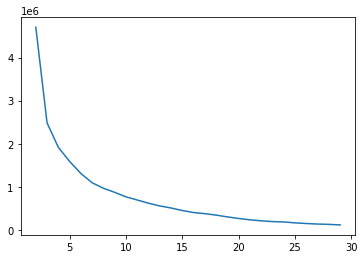

In [19]:
import matplotlib.pyplot as plt

TSS = []
for i in range(2,30):
    km = KMeans(n_clusters=i,random_state=0)
    km.fit(pca_fit)
    TSS.append(km.inertia_)
plt.plot(range(2,30),TSS,'-')

we have to use silhouette analysis to find the right k. Silhouette score is a metric for validation of the clustering. We will calculate the silhouette score for each trial of k.

In [20]:
for n in [30]:
    km = KMeans(n_clusters=n,random_state=0)
    clusters = km.fit_predict(pca_fit)
    silhouette_avg = silhouette_score(pca_fit, clusters)
    print("For n_clusters =", n,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_values = silhouette_samples(pca_fit, clusters)

For n_clusters = 30 The average silhouette_score is : 0.8494697614240041


In [21]:
from pandas.core.groupby import DataFrameGroupBy
Kmeans_final = KMeans(n_clusters=30,random_state=0).fit(pca_fit)
userRatings['cluster'] = Kmeans_final.labels_

In [22]:
#function take user id and find the recommended movie 
#first i take user id and find the cluster for that user then i pick the most rated film in this cluster
def recomend_movie(user_id):
  for i in range(30):
     Ser=userRatings[userRatings.cluster == i].index
     cl_user= df2[df2['user'].isin(list(Ser))]
     dd=cl_user.loc[cl_user['user'] == user_id]
     if(dd.empty):
       empty=dd
     else:
       print(cl_user.groupby('movie_name')['rating'].mean().sort_values(ascending=False).head(10))


In [23]:
recomend_movie(79)

movie_name
Aqua Teen Hunger Force: Vol. 1                           4.159375
ABC Primetime: Mel Gibson's The Passion of the Christ    4.046154
Invader Zim                                              4.036145
I Love Lucy: Season 2                                    4.005952
Isle of Man TT 2004 Review                               4.000000
Class of Nuke 'Em High 2                                 4.000000
Inspector Morse 31: Death Is Now My Neighbour            3.987654
Seeta Aur Geeta                                          3.888889
The Rise and Fall of ECW                                 3.849057
Classic Albums: Meat Loaf: Bat Out of Hell               3.800000
Name: rating, dtype: float64


In [33]:
#take movie name and find the recommended movie for that movie 
#here we found the cluster for this movie and i get the most rated movie in this cluster
def recommende_film(movi_name):
    for i in range(30):
        Ser=userRatings[userRatings.cluster == i].index
        cl_user= df2[df2['user'].isin(list(Ser))]
        dd=cl_user.loc[cl_user['movie_name']==(movi_name)]
        if(dd.empty):
            empty=dd
        else:
           movie=cl_user.groupby('movie_name')['rating'].mean().sort_values(ascending=False).head(10)
           print(movie)
           break


In [34]:
recommende_film('Sick')

movie_name
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material    4.250000
Aqua Teen Hunger Force: Vol. 1                                                 4.233918
Invader Zim                                                                    4.094340
Character                                                                      4.037736
Zatoichi's Conspiracy                                                          4.000000
Davy Crockett: 50th Anniversary Double Feature                                 4.000000
Grind                                                                          4.000000
Devo: The Complete Truth About De-evolution                                    4.000000
Ricky Martin: One Night Only                                                   4.000000
A Yank in the R.A.F.                                                           4.000000
Name: rating, dtype: float64
